In [15]:
# First import a bunch of useful stuff

import os, subprocess
import json
import uproot
import awkward as ak
import numpy as np
from coffea import processor, util, hist

%matplotlib inline
import matplotlib.pyplot as plt
from cycler import cycler

import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.CMS])

In [16]:
# This gives the integrated luminosity (the amount of data collected) for each year
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

In [17]:
# This gives the number of files of simulated date for each year
nfiles_mc = {}
nfiles_mc['2016'] = 112
nfiles_mc['2017'] = 161
nfiles_mc['2018'] = 193

In [18]:
# This dictionary gives the cross section (expected rate) of each simulated process
# Number of events of process P = integrated luminosity * cross section of process P
with open('xsec.json') as f:
  xs = json.load(f)
print(xs)

{'QCD_HT300to500_TuneCP5_13TeV-madgraphMLM-pythia8': 322600, 'QCD_HT500to700_TuneCP5_13TeV-madgraphMLM-pythia8': 29980, 'QCD_HT700to1000_TuneCP5_13TeV-madgraphMLM-pythia8': 6334, 'QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8': 1088, 'QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8': 99.11, 'QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8': 20.23, 'QCD_HT300to500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 347700, 'QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 32100, 'QCD_HT700to1000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 6831, 'QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 1207, 'QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 119.9, 'QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 25.24, 'WJetsToQQ_HT400to600_qc19_3j_13TeV-madgraphMLM-pythia8': 315.6, 'WJetsToQQ_HT600to800_qc19_3j_13TeV-madgraphMLM-pythia8': 68.57, 'WJetsToQQ_HT800toInf_qc19_3j_13TeV-madgraphMLM-pythia8': 34.9, 'ZJetsToQQ_HT400to600_qc19_4j_13TeV-madgraphMLM-pythia8':

In [19]:
# This dictionary tells us how to group the simulated samples together sensibly
# For example, QCD is generated separately for different energies. Combine them
with open('pmap_mc.json') as f:
  pmap = json.load(f)
print(pmap)

{'ZH': ['ZH_HToBB_ZToQQ_M125_13TeV_powheg_pythia8', 'ZH_HToBB_ZToNuNu_M125_13TeV_powheg_pythia8', 'ggZH_HToBB_ZToQQ_M125_13TeV_powheg_pythia8', 'ggZH_HToBB_ZToNuNu_M125_13TeV_powheg_pythia8'], 'WH': ['WminusH_HToBB_WToQQ_M125_13TeV_powheg_pythia8', 'WplusH_HToBB_WToQQ_M125_13TeV_powheg_pythia8'], 'ttH': ['ttHToBB_M125_13TeV-powheg-pythia8'], 'VBF': ['VBFHToBB_M125_13TeV_powheg_pythia8'], 'ggF': ['GluGluHToBB_M125_13TeV_powheg_MINLO_NNLOPS_pythia8'], 'QCD': ['QCD_HT500to700_TuneCP5_13TeV-madgraphMLM-pythia8', 'QCD_HT700to1000_TuneCP5_13TeV-madgraphMLM-pythia8', 'QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8', 'QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8', 'QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8', 'QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8', 'QCD_HT700to1000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8', 'QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8', 'QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8', 'QCD_HT2000toInf_TuneCUETP8M1_13TeV-mad

In [20]:
# I like to run this for one year at a time
year = '2017'
outsum = processor.dict_accumulator()

In [21]:
# Higgs mass window
mbb_min = 110
mbb_max = 138

In [22]:
# Number-counting significance as a function of the number of signal (s) and background (b) events
def significance(s,b):
    if b==0:
        return 0
    z_squared = 2.0*(s+b)*np.log(1.0+1.0*s/b) - 2.0*s
    return np.sqrt(z_squared)

In [23]:
# Plotting function where processes are overlaid in a variable name
def plot_overlay(x,name):
    x.label = 'Events'
    axes = hist.plotgrid(x, overlay='process', line_opts={}, order=['QCD','Zjets','Wjets','ttbar','singlet','VV','ggF','VBF','WH','ZH','ttH'])
    axes[0, 0].set_prop_cycle(cycler(color=colors.values()))
    axes[0, 0].set_yscale('log')
    axes[0, 0].set_ylim(.001, 100000)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    png_name = year+'/plot-all/'+name+'.png'
    plt.savefig(png_name,bbox_inches='tight')
    pdf_name = year+'/plot-all/'+name+'.pdf'
    plt.savefig(pdf_name,bbox_inches='tight')

In [24]:
# Plotting function where processes are stacked in a variable name
def plot_stack(x,name):
    x.label = 'Events'
    axes = hist.plot1d(x, overlay='process', fill_opts={'edgecolor': (0,0,0,1)}, stack=True, order=['ttH','ZH','WH','VBF','ggF','VV','ttbar','singlet','Wjets','Zjets','QCD'])
    axes.set_prop_cycle(cycler(color=colors.values()))
    axes.set_yscale('log')
    axes.set_ylim(.001, 100000)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    png_name = year+'/plot-all/'+name+'_stack.png'
    plt.savefig(png_name,bbox_inches='tight')
    pdf_name = year+'/plot-all/'+name+'_stack.pdf'
    plt.savefig(pdf_name,bbox_inches='tight')

In [25]:
# Load all simulated data files
for n in range(1,nfiles_mc[year]+1):
    print(n)
    filename = 'condor/outfiles/'+year+'_'+str(n)+'.coffea'
    if os.path.isfile(filename):
        out = util.load(filename)
        outsum.add(out)
    else:
        print("File " + filename + " is missing")
        
# Scale factor accounts for luminosity and cross section
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
outsum['templates1'].scale(scale_lumi, 'dataset')

# Any missing files will be listed here. Let me know so I can find/fix them

1
2
File condor/outfiles/2017_2.coffea is missing
3
File condor/outfiles/2017_3.coffea is missing
4
File condor/outfiles/2017_4.coffea is missing
5
File condor/outfiles/2017_5.coffea is missing
6
File condor/outfiles/2017_6.coffea is missing
7
File condor/outfiles/2017_7.coffea is missing
8
File condor/outfiles/2017_8.coffea is missing
9
File condor/outfiles/2017_9.coffea is missing
10
File condor/outfiles/2017_10.coffea is missing
11
File condor/outfiles/2017_11.coffea is missing
12
File condor/outfiles/2017_12.coffea is missing
13
File condor/outfiles/2017_13.coffea is missing
14
File condor/outfiles/2017_14.coffea is missing
15
File condor/outfiles/2017_15.coffea is missing
16
File condor/outfiles/2017_16.coffea is missing
17
File condor/outfiles/2017_17.coffea is missing
18
File condor/outfiles/2017_18.coffea is missing
19
File condor/outfiles/2017_19.coffea is missing
20
File condor/outfiles/2017_20.coffea is missing
21
File condor/outfiles/2017_21.coffea is missing
22
File condor

In [26]:
# Use pmap to group the datasets together
templates = outsum['templates1'].group('dataset', hist.Cat('process', 'Process'), pmap)

# Select out the signal region
templates = templates.integrate('region', 'signal')

/uscms_data/d3/jennetd/hbb-prod-modes/february-2021/vbf-ddbopt/coffeaenv/lib/python3.7/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f5a6f911bd0>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


In [29]:
# Print the total number of events per process
templates.sum('msd1','pt1','deta','mjj','ddb1').values()

{('ZH',): 0.0}

In [30]:
# Sum the histogram over all but one variable
x = templates.sum('pt1','deta','mjj','ddb1')

KeyError: ()

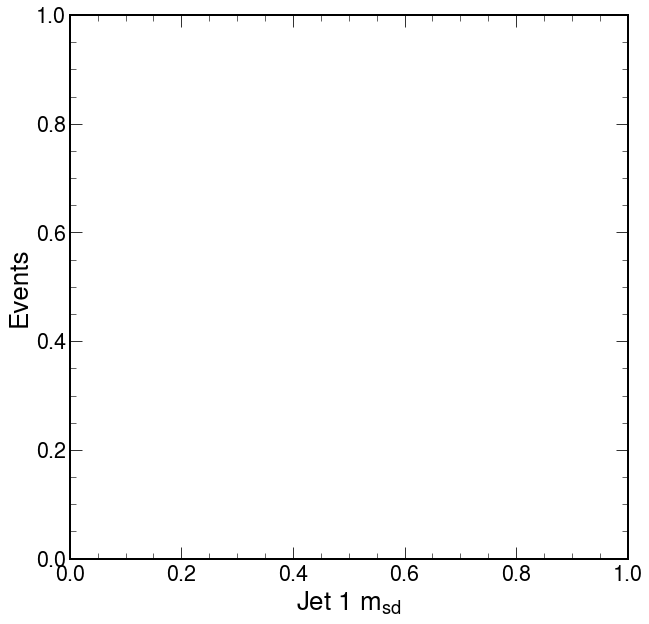

In [33]:
# draw the overlay plot
plot_overlay(x,'msd1')

KeyError: ()

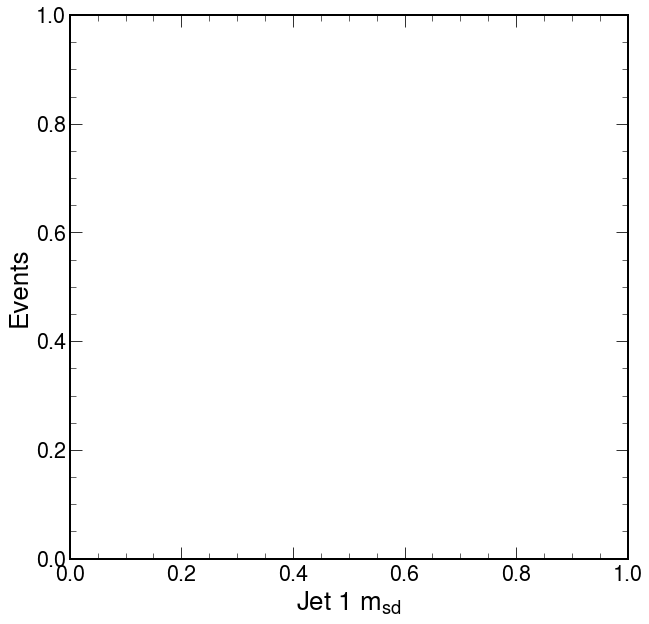

In [34]:
# draw the stacked plot
plot_stack(x,'msd1')

In [35]:
# Select out events in the Higgs mass window
templates_window=templates.integrate('msd1',int_range=slice(mbb_min,mbb_max))

In [37]:
# Apply a cut
templates_cut = templates_window.integrate('deta',int_range=slice(3.5,7)).integrate('mjj',int_range=slice(1000,4000))

# Print the number of events passing the cut per process
templates_cut.sum('pt1','ddb1').values()

{('ZH',): 0.0}

In [38]:
sr = templates_cut.sum().values()

# Get the number of signal and background events
s = sr[('VBF',)] 
b = sr[('QCD',)] + sr[('Zjets',)] + sr[('Wjets',)] + sr[('VV',)] + sr[('ttbar',)] +sr[('singlet',)] + sr[('ggF',)] + sr[('WH',)] + sr[('ZH',)] + sr[('ttH',)]

# Print the significance
print(significance(s,b))
# Note: this only makes sense in the mass window of Higgs

KeyError: ('VBF',)